In [1]:
import tensorflow as tf
from kapre.time_frequency import Melspectrogram,Spectrogram
from kapre.utils import Normalization2D
from tensorflow.keras import backend as K
from google.colab import drive
import os
import numpy as np
import librosa.display
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import IPython.display as ipd
drive.mount('/content/drive')

Mounted at /content/drive


#Data Reading

In [2]:
def get_train_val_split(X_filepath, y_filepath, train_perc = 75, val_perc = 10):
    
    with open(X_filepath, 'rb') as load_file:
        data_X = np.load(load_file)
    with open(y_filepath, 'rb') as load_file:
        data_y = np.load(load_file)
    
    def standardize(X):
        return (X - X.mean()) / (X.std() + 0.000001)
    data_X = standardize(data_X)
    
    test_perc = 100 - (train_perc + val_perc)
    train_val_X, test_X, train_val_y, test_y = train_test_split(data_X, data_y, 
                                                                test_size = test_perc / 100, stratify = np.argmax(data_y, axis = 1), random_state = 42)
    train_X, val_X, train_y, val_y = train_test_split(train_val_X, train_val_y, 
                                                      test_size = val_perc / (train_perc + val_perc), stratify = np.argmax(train_val_y, axis = 1),random_state = 42)
    return train_X, train_y, val_X, val_y, test_X, test_y


EMOTIONS = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised']

X_filepath = '/content/drive/MyDrive/8th sem/audio_project/dataset/Processed_Data/data_X.npy'
y_filepath = '/content/drive/MyDrive/8th sem/audio_project/dataset/Processed_Data/data_y.npy'

train_x,train_y,val_x,val_y,test_x,test_y = get_train_val_split(X_filepath,y_filepath)
train_x = np.expand_dims(train_x,axis=3)
test_x = np.expand_dims(test_x,axis=3)
val_x = np.expand_dims(val_x,axis=3)
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(test_x.shape)
print(test_y.shape)



(1080, 228, 128, 1)
(1080, 8)
(144, 228, 128, 1)
(144, 8)
(216, 228, 128, 1)
(216, 8)


#RNN model with weighted attention unit

In [3]:
def RNNSpeechModel(no_of_classes, input_size):
  
  # x = tf.keras.layers.Input((input_len,))
  # x = tf.keras.layers.Reshape((1,-1))(x)
  # m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, input_len),
  #                      padding='same', sr=sr, n_mels=80,
  #                      fmin=40.0, fmax=sr / 2, power_melgram=1.0,
  #                      return_decibel_melgram=True, trainable_fb=False,
  #                      trainable_kernel=False,
  #                      name='mel_stft')
  # m.trainable = False
  # x = m(x)
  #x = Normalization2D(int_axis=0)(x)
  #x = tf.keras.layers.Permute((2,1,3))(x)

  input = tf.keras.layers.Input((input_size))
  #Bidirectional RNN
  x = tf.keras.layers.Conv2D(10,(5,1),activation='relu',padding = 'same')(input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(1,(5,1),activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Lambda(lambda q: K.squeeze(q, -1))(x)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences = 'true'))(x)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences = 'true'))(x)

  #Attention unit
  xFirst = tf.keras.layers.Lambda(lambda q: q[:,-1])(x)
  query = tf.keras.layers.Dense(128)(xFirst)
  att_score = tf.keras.layers.Dot(axes=[1,2])([query,x])
  att_score = tf.keras.layers.Softmax()(att_score)

  #weighted pooling
  att_vector = tf.keras.layers.Dot(axes=[1,1])([att_score,x])
  x = tf.keras.layers.Dense(64,activation='relu')(att_vector)
  x = tf.keras.layers.Dense(32,activation='relu')(x)
  output = tf.keras.layers.Dense(8,activation='softmax')(x)

  model = tf.keras.models.Model(inputs = input,outputs = output)
  return model
  
no_of_classes = 8
input_size = train_x[0].shape
model_speech = RNNSpeechModel(no_of_classes,input_size)
model_speech.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model_speech.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 228, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 228, 128, 10) 60          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 228, 128, 10) 40          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 228, 128, 1)  51          batch_normalization[0][0]        
______________________________________________________________________________________________

#Training

In [4]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss' ,
                                                  factor = 0.5 , patience = 5 , verbose=1 , cooldown = 1,
                                                 min_delta = 0.000001)

checkpoint_filepath = '/content/drive/MyDrive/8th sem/audio_project/checkpoint_weights.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    verbose = 1,
    save_best_only=True)

history = model_speech.fit(x = train_x, y=train_y, batch_size=32, 
                           validation_data=(val_x,val_y), steps_per_epoch = len(train_x)//32,
                           validation_steps=len(val_x)//32,
                           epochs = 100,callbacks = [reduce_lr,model_checkpoint_callback])

# history = model_speech.fit_generator(train_generator , validation_data = validation_generator , 
#                                   steps_per_epoch= len(train_generator) ,
#                                   validation_steps = len(validation_generator)
#                                   ,epochs = 100,callbacks = [reduce_lr,model_checkpoint_callback] )

Epoch 1/100
33/33 [==============================] - 40s 94ms/step - loss: 2.0806 - acc: 0.1446 - val_loss: 2.0620 - val_acc: 0.1406

Epoch 00001: val_acc improved from -inf to 0.14062, saving model to /content/drive/MyDrive/8th sem/audio_project/checkpoint_weights.h5
Epoch 2/100
33/33 [==============================] - 2s 48ms/step - loss: 1.8992 - acc: 0.2581 - val_loss: 2.0960 - val_acc: 0.1406

Epoch 00002: val_acc did not improve from 0.14062
Epoch 3/100
33/33 [==============================] - 2s 48ms/step - loss: 1.6197 - acc: 0.4249 - val_loss: 2.2785 - val_acc: 0.1406

Epoch 00003: val_acc did not improve from 0.14062
Epoch 4/100
33/33 [==============================] - 2s 48ms/step - loss: 1.4655 - acc: 0.4575 - val_loss: 2.4467 - val_acc: 0.1406

Epoch 00004: val_acc did not improve from 0.14062
Epoch 5/100
33/33 [==============================] - 2s 48ms/step - loss: 1.2433 - acc: 0.5526 - val_loss: 2.7774 - val_acc: 0.1406

Epoch 00005: val_acc did not improve from 0.14062

#Results and Plots

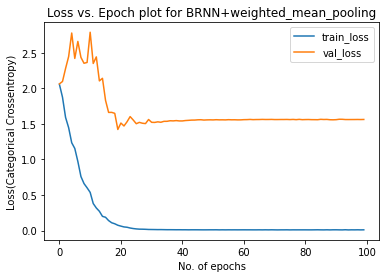

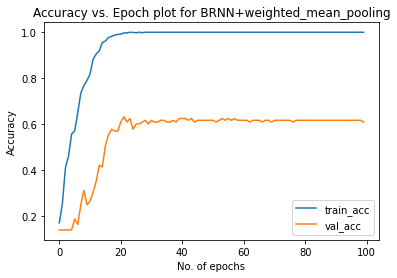

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '




Precision 0.6733435448959643
Recall 0.6596366995073891
Accuracy 0.6759259259259259
F1 0.6608015335363678
jaccard 0.5063883344793672





In [15]:
model_speech.load_weights('/content/drive/MyDrive/8th sem/audio_project/checkpoint_weights.h5')
#model.save('')

plt.plot(history.history['loss'] , label = 'train_loss')
plt.plot(history.history['val_loss'] , label = 'val_loss')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss(Categorical Crossentropy)")
plt.title("Loss vs. Epoch plot for BRNN+weighted_mean_pooling")
plt.show()

plt.plot(history.history['acc'] , label = 'train_acc')
plt.plot(history.history['val_acc'] , label = 'val_acc')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch plot for BRNN+weighted_mean_pooling")
plt.show()



#print('original')
orig = np.argmax(test_y,axis=1) 
#print(orig)
#print('\n')
#print('predicted')
pred = model_speech.predict_generator(test_x , steps = 32 , verbose = 0)
pred_class_indices = np.argmax(pred,axis=1)
#print(pred_class_indices)
#print('\n')


print('\n')
from sklearn.metrics import precision_score,recall_score,accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score,jaccard_score,classification_report
print('Precision {}'.format(precision_score(y_true=orig, y_pred=pred_class_indices,average = 'macro')))
print('Recall {}'.format(recall_score(y_true=orig, y_pred=pred_class_indices,average='macro')))
print('Accuracy {}'.format(accuracy_score(y_true=orig, y_pred=pred_class_indices)))
print('F1 {}'.format(f1_score(y_true=orig, y_pred=pred_class_indices,average = 'macro')))
print('jaccard {}'.format(jaccard_score(y_true=orig, y_pred=pred_class_indices,average = 'macro')))
#print('confusion_matrix\n {}'.format(confusion_matrix(y_true=orig, y_pred=pred_class_indices)))
#print('classification_report\n {}'.format(classification_report(y_true=orig, y_pred=pred_class_indices)))
print('\n\n')


met = np.zeros((9,5))

avg_met = [precision_score(y_true=orig, y_pred=pred_class_indices,average = 'macro'),
           recall_score(y_true=orig, y_pred=pred_class_indices,average='macro'),
           f1_score(y_true=orig, y_pred=pred_class_indices,average = 'macro'),
           jaccard_score(y_true=orig, y_pred=pred_class_indices,average = 'macro'),
           accuracy_score(y_true=orig, y_pred=pred_class_indices)]

avg_met = np.array(avg_met)
avg_met.round(decimals=2)
met[8,:] = avg_met

#print(met)


#Class Wise Results

In [16]:
classes = [0,1,2,3,4,5,6,7]


for cl in classes:

    print("class: ",EMOTIONS[cl])

    a1 = np.uint8(orig == cl)
    a2 = np.uint8(pred_class_indices == cl)

    print('Accuracy {}'.format(accuracy_score(y_true=a1, y_pred=a2)))
    print('F1 {}'.format(f1_score(y_true=a1, y_pred=a2)))
    print('precision {}'.format(precision_score(y_true=a1, y_pred=a2)))
    print('recall {}'.format(recall_score(y_true=a1, y_pred=a2)))

    print('jaccard {}'.format(jaccard_score(y_true=a1, y_pred=a2)))
    print("_______________________________")


    class_met = [precision_score(y_true=a1, y_pred=a2),
                 recall_score(y_true=a1, y_pred=a2),
                 f1_score(y_true=a1, y_pred=a2),
                 jaccard_score(y_true=a1, y_pred=a2),
                 accuracy_score(y_true=a1, y_pred=a2)]

    class_met = np.array(class_met)
    class_met.round(decimals=2)
    met[cl,:] =class_met

class:  Neutral
Accuracy 0.9212962962962963
F1 0.4137931034482759
precision 0.4
recall 0.42857142857142855
jaccard 0.2608695652173913
_______________________________
class:  Calm
Accuracy 0.9166666666666666
F1 0.6538461538461539
precision 0.7083333333333334
recall 0.6071428571428571
jaccard 0.4857142857142857
_______________________________
class:  Happy
Accuracy 0.9074074074074074
F1 0.6875
precision 0.6285714285714286
recall 0.7586206896551724
jaccard 0.5238095238095238
_______________________________
class:  Sad
Accuracy 0.8611111111111112
F1 0.5161290322580646
precision 0.48484848484848486
recall 0.5517241379310345
jaccard 0.34782608695652173
_______________________________
class:  Angry
Accuracy 0.9166666666666666
F1 0.7
precision 0.6774193548387096
recall 0.7241379310344828
jaccard 0.5384615384615384
_______________________________
class:  Fearful
Accuracy 0.9444444444444444
F1 0.8064516129032258
precision 0.7575757575757576
recall 0.8620689655172413
jaccard 0.6756756756756757
__

#Confusion Matrix

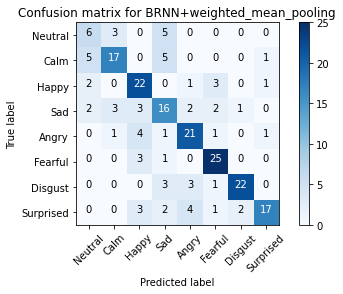

In [17]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true=orig, y_pred=pred_class_indices)
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # if normalize:
    #     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #     print("Normalized confusion matrix")
    # else:
    #     print('Confusion matrix, without normalization')

    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(cm, EMOTIONS,
                        normalize=False,
                        title='Confusion matrix for BRNN+weighted_mean_pooling',
                        cmap=plt.cm.Blues)